# 2D Shallow Neural Network Position Model

### Load Data

In [1]:
WINDOW_SIZE = 10

In [2]:
%store -r many_many_short

df = many_many_short
sideways = df.T

X, Y = np.array(sideways['dist0':'theta{}'.format(WINDOW_SIZE-1)]), np.array(sideways.ix['label']).astype(int)

### Train

In [3]:
from nn.deep.model import NeuralNetwork

nn = NeuralNetwork(X, Y, Hs=[5], C=2, learning_rate=.1, regularizer=.001, gradient_checking=False, inspect=True)

def states(iters):
    for _ in range(iters):
        nn.learn()
        yield nn.info
        
states = list(states(5000))

### Plot Losses

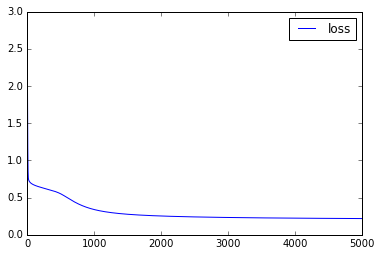

In [4]:
def loss_averages():
    for state in states:
        yield state.gradients['loss'].mean()
        
loss_avgs = list(loss_averages())

pd.DataFrame(loss_avgs, columns=['loss']).plot()

### Visualize

/home/ebanner/.anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/ebanner/.anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/ebanner/.anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/ebanner/.anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


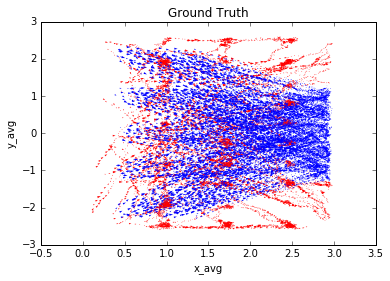

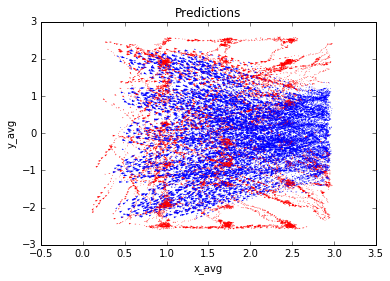

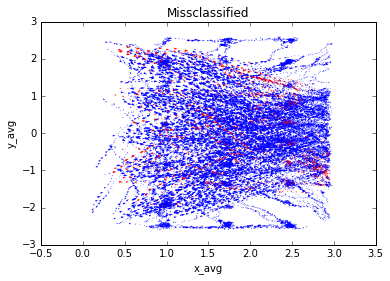

In [5]:
from ipywidgets import interact, fixed

@interact(X=fixed(X), Y=fixed(Y), view_index=(0, len(states)-1), states=fixed(states))
def plot(X, Y, view_index, states):
    """View decision boundary over time
    
    We have the state of the model (i.e. its parameters) after every time step.
    We want to see how the model learns over time. Hence create a one-off instance
    of a softmax with its old parameters and ask it to make a bunch of predictions!
    """
    s = states[view_index]
    nn = NeuralNetwork(X, Y, Hs=[5], C=2, params=s.params)
    
    # Plotting
    colormap = np.array(['r', 'b'])

    # Plot the gold standard in a plot right next to it
    axes = df.plot(kind='scatter', x='x_avg', y='y_avg', c=colormap[df['label']], title='Ground Truth', s=0)
    axes.quiver(df['x_avg'], df['y_avg'], df['dx_avg'], df['dy_avg'], color=colormap[df['label']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

    # Predictions
    df['predictions'] = nn.predict(X)
    axes = df.plot(kind='scatter', x='x_avg', y='y_avg', c=colormap[df['predictions']], title='Predictions', s=0)
    axes.quiver(df['x_avg'], df['y_avg'], df['dx_avg'], df['dy_avg'], color=colormap[df['predictions']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

    # Misclassified examples
    df['correct'] = df['label'] == df['predictions']
    axes = df.plot(kind='scatter', x='x_avg', y='y_avg', c=colormap[df['correct']], title='Missclassified', s=0)
    axes.quiver(df['x_avg'], df['y_avg'], df['dx_avg'], df['dy_avg'], color=colormap[df['correct']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

In [6]:
df.correct.sum().astype(float) / len(df)

0.90859592711682746

### Serialize the Model

In [7]:
import pickle

nn = NeuralNetwork(X[:,:1], Y[:1], Hs=[5], C=2, params=states[-1].params)

model = {'clf': nn, 'features': 'distance+bearing', 'window_size': WINDOW_SIZE}

with open('/home/ebanner/nao/trunk/model.p', 'wb') as f:
    pickle.dump(model, f)